# Imports

In [1]:
# Install requirements from requirements file
# pip install -r ../requirements.txt

# Alternative: Install requirements directly
# %pip install blosum
# %pip install Bio
# %pip install torch torchvision torchaudio transformers sentencepiece accelerate --extra-index-url https://download.pytorch.org/whl/cu116
# %pip install protein-bert
# %pip install biopython biotite
# %pip install fair-esm
# %pip install scipy
# %pip install matplotlib
# %pip install seaborn

In [3]:
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
from scipy.stats import t
import blosum as bl
from Bio import SeqIO
import random
from scipy import stats
import torch
import esm
import re
import os
from tqdm import tqdm
import seaborn as sns
import re
import random
import pickle
import statistics
import tensorflow as tf
import time
from zipfile import ZipFile
import sys
sys.path.insert(0, "../")

# Importing models and embeddings retrieval methods
from models import get_model
from embeddings import get_fasta_embeddings, get_pair_embeddings, load_fasta, get_embeddings_T5

# Retrieve the device (CPU or GPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: {}".format(device))

torch.set_grad_enabled(False)

import warnings
warnings.filterwarnings("ignore")

# Available models
MODELS_LIST = ["ProtT5", "ProtBert", "ProtAlbert", "ProtXLNet"]

# Available alignment types
ALIGNMENT_TYPES = ["Global-regular" , "Global-end-gap-free"]

2024-03-26 12:46:25.916798: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda:0
Using device: cuda:0


# Alignment Algorithms

## Global

In [4]:
def affine_global_dp(seq_1, seq_2, g_open, g_ext,
                     scoring="ProtT5", Model=None, Model_tokenizer=None):
    """ Performs global alignment of two sequences using affine gap penalty dynamic programming algorithm """
    m, n = len(seq_1), len(seq_2)

    # Initialize matrices
    M = np.zeros([m + 1, n + 1])
    M[0, 1:] = g_open + g_ext * np.arange(0, n, 1)
    M[1:, 0] = g_open + g_ext * np.arange(0, m, 1)

    # Copies to avoid Gotoh's error
    L, U = np.copy(M), np.copy(M)
    L[1:, 0] += g_open
    U[0, 1:] += g_open

    # Tracer matrix
    tracer = np.zeros([np.shape(M)[0], np.shape(M)[1], 7])
  
    # Get embeddings
    emb1, emb2 = get_pair_embeddings(seq_1, seq_2, Model, Model_tokenizer, scoring)
    cos = torch.nn.CosineSimilarity(dim=0)

    # Dynamic programming algorithm
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            l_arr = np.array([M[i, j - 1] + g_open, L[i, j - 1] + g_ext])
            L[i, j] = np.max(l_arr)
            l_where = l_arr == np.max(l_arr)

            u_arr = np.array([M[i - 1, j] + g_open, U[i - 1, j] + g_ext])
            U[i, j] = np.max(u_arr)
            u_where = u_arr == np.max(u_arr)

            if scoring in MODELS_LIST:
                sim = cos(torch.tensor(emb1[i - 1], dtype=torch.float32), 
                          torch.tensor(emb2[j - 1], dtype=torch.float32)).item()
                m_arr = np.array([M[i - 1, j - 1] + sim, U[i, j], L[i, j]])

            M[i, j] = np.max(m_arr)
            m_where = m_arr == np.max(m_arr)

            idx = np.hstack([m_where, u_where, l_where])
            tracer[i, j, idx] = 1

    # Traceback
    alignment = traceback_g(tracer, seq_1, seq_2, affine=True)
    alignment = list(set(map(tuple, alignment)))

    return M, L, U, tracer, alignment


def traceback_g(tracer, seq_1, seq_2, mat=None, affine=False, roadmap=0):
    """ Performs traceback step of the sequence alignment algorithm - reconstructs aligned sequences from the tracer matrix 
    Based on Smith-Waterman algorithm
    """
    # Get sequence lengths
    m, n = len(seq_1), len(seq_2)

    # Convert to numpy arrays
    x = np.array(list(seq_1), dtype='object')
    y = np.array(list(seq_2), dtype='object')

    # Set start location
    st = [m + 1, n + 1]
    st_lv = 0  # Start in midgard

    while st[0] > 1 and st[1] > 1:
        B = np.zeros([2, 2])  # define 2x2 box which specifies which way to move

        Tr_size = 7 if affine else 3  # Size of tracer array
        Tr = np.zeros([Tr_size])  # define a Tr_size x 1 Tr array (will store arrows at each step)

        # Get tracer array
        for i in range(Tr_size):
            Tr[i] = np.copy(tracer[st[0] - 1, st[1] - 1, i])

        # Bifurcations
        levels = [[2, 0, 1], [4, 3], [6, 5]] if affine else [[2, 0, 1]]

        for l in levels:
            if np.sum(Tr[l]) > 1:
                choose = np.where(Tr[l] == 1)[0]
                Tr[l] = 0
                r = np.random.choice(choose, 1)[0] if roadmap == 0 else choose[-1] if roadmap == 1 else choose[0]
                if roadmap not in [0, 1, 2]:
                    raise Exception("roadmap only accepts 0: random turning, 1: highroad, 2: lowroad")
                Tr[l[r]] = 1

        # Diagonal
        if Tr[0] == 1 and st_lv == 0:
            B[0, 0] = 1

        # End gaps
        if Tr[1] == 1 and st_lv == 0:
            if affine:
                st_lv = 1  # level up
            else:
                B[0, 1] = 1

        if Tr[2] == 1 and st_lv == 0:
            if affine:
                st_lv = 2  # level down
            else:
                B[1, 0] = 1

        # Affine gaps allow for level shifts
        if affine:
            if Tr[4] == 1 and st_lv == 1:  # move up
                B[0, 1] = 1

            if Tr[3] == 1 and st_lv == 1:  # move up back to main
                st_lv = 0
                B[0, 1] = 1

            if Tr[6] == 1 and st_lv == 2:  # move left
                B[1, 0] = 1

            if Tr[5] == 1 and st_lv == 2:  # move left back to main
                st_lv = 0
                B[1, 0] = 1

        # Movements
        if B[0, 1] == 1:  # upward
            y = np.insert(y, st[1] - 1, '-')  # add a gap
            st[0] -= 1

        if B[1, 0] == 1:  # leftward
            x = np.insert(x, st[0] - 1, '-')  # add a gap
            st[1] -= 1

        if B[0, 0] == 1:  # diagonal
            st[1] -= 1
            st[0] -= 1

    # Some end gaps are left when you hit the upper/lower end of the matrix or a 0
    end_size = np.size(x) - np.size(y)  # how many gaps and for which sequence
    end_gap = ['-'] * abs(end_size)
    if end_size > 0:
        y = np.insert(y, 0, end_gap)
    elif end_size < 0:
        x = np.insert(x, 0, end_gap)

    # Check no overlapping gaps
    x = np.where(((x == '-') & (y == '-')), None, x)
    y = np.where((x == None), '', y)
    x = np.where((x == None), '', x)

    return np.sum(x), np.sum(y)

## Prefix/Suffix

In [5]:
def affine_semi_global_dp(seq_1, seq_2, g_open, g_ext,
                          high_low=False, scoring="ProtT5", Model=None, Model_tokenizer=None):
    """ Performs semi-global alignment of two sequences using affine gap penalty dynamic programming algorithm """
    m, n = len(seq_1), len(seq_2)
    
    # Initialize matrices
    M = np.zeros([m + 1, n + 1])
    L, U = np.copy(M), np.copy(M)

    # Tracer matrix
    tracer = np.zeros([np.shape(M)[0], np.shape(M)[1], 7])

    # Get embeddings
    emb1, emb2 = get_pair_embeddings(seq_1, seq_2, Model, Model_tokenizer, scoring)
    cos = torch.nn.CosineSimilarity(dim=0)

    # Dynamic programming algorithm
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            l_arr = np.array([M[i, j - 1] + g_open, L[i, j - 1] + g_ext])
            L[i, j] = np.max(l_arr)
            l_where = l_arr == np.max(l_arr)

            u_arr = np.array([M[i - 1, j] + g_open, U[i - 1, j] + g_ext])
            U[i, j] = np.max(u_arr)
            u_where = u_arr == np.max(u_arr)

            if scoring in MODELS_LIST:
                sim = cos(torch.tensor(emb1[i - 1], dtype=torch.float32), 
                          torch.tensor(emb2[j - 1], dtype=torch.float32)).item()
                m_arr = np.array([M[i - 1, j - 1] + sim, U[i, j], L[i, j]])

            M[i, j] = np.max(m_arr)
            m_where = m_arr == np.max(m_arr)

            idx = np.hstack([m_where, u_where, l_where])
            tracer[i, j, idx] = 1

    alignment = [traceback_sg(tracer, seq_1, seq_2, mat=M, affine=True, local= True, roadmap=0)]
    alignment = list(set(map(tuple, alignment)))

    return M, L, U, tracer, alignment


def traceback_sg(tracer, seq_1, seq_2, mat=None, local=False, affine=False, roadmap=0):
    """ Performs traceback step of the sequence alignment algorithm - reconstructs aligned sequences from the tracer matrix """
    m, n = len(seq_1), len(seq_2)

    # Convert to numpy arrays
    x = np.array(list(seq_1), dtype='object')
    y = np.array(list(seq_2), dtype='object')

    # Set start location (random maxima if 0)
    r = np.random.choice(range(np.size(np.where(mat == np.max(mat))[0])), 1)[0] if roadmap == 0 else -1 if roadmap == 1 else 0
    st = [(np.where(mat == np.max(mat))[0][r]) + 1, (np.where(mat == np.max(mat))[1][r]) + 1]

    # Set starting gaps based on the start location
    start_size = (m - st[0]) - (n - st[1])  # how many gaps and for which sequence
    start_gap = (['-'] * abs(start_size))
    if start_size > 0:
        y = np.append(y, start_gap)
    elif start_size < 0:
        x = np.append(x, start_gap)

    st_lv = 0  # start in midgard

    while st[0] > 1 and st[1] > 1:
        B = np.zeros([2, 2])  # define 2x2 box which specifies which way to move

        Tr_size = 7 if affine else 3  # size of tracer array
        Tr = np.zeros([Tr_size])  # define a Tr_size x 1 Tr array (will store arrows at each step)

        # Tracer
        for i in range(Tr_size):
            Tr[i] = np.copy(tracer[st[0] - 1, st[1] - 1, i])

        # Bifurcations
        levels = [[2, 0, 1], [4, 3], [6, 5]] if affine else [[2, 0, 1]]

        for l in levels:
            if np.sum(Tr[l]) > 1:
                choose = np.where(Tr[l] == 1)[0]
                Tr[l] = 0
                # 0: random turning, 1: highroad, 2: lowroad
                r = np.random.choice(choose, 1)[0] if roadmap == 0 else choose[-1] if roadmap == 1 else choose[0]
                if roadmap not in [0, 1, 2]:
                    raise Exception("roadmap only accepts 0: random turning, 1: highroad, 2: lowroad")
                
                Tr[l[r]] = 1

        # level up-down
        if Tr[0] == 1 and st_lv == 0:  # diagonal
            B[0, 0] = 1

        if Tr[1] == 1 and st_lv == 0:
            if affine:
                st_lv = 1  # level up
            else:
                B[0, 1] = 1

        if Tr[2] == 1 and st_lv == 0:
            if affine:
                st_lv = 2  # level down
            else:
                B[1, 0] = 1

        # Affine gaps allow for level shifts
        if affine:
            if Tr[4] == 1 and st_lv == 1:  # move up
                B[0, 1] = 1

            if Tr[3] == 1 and st_lv == 1:  # move up back to main
                st_lv = 0
                B[0, 1] = 1

            if Tr[6] == 1 and st_lv == 2:  # move left
                B[1, 0] = 1

            if Tr[5] == 1 and st_lv == 2:  # move left back to main
                st_lv = 0
                B[1, 0] = 1

        if local and mat[st[0] - 1, st[1] - 1] == 0:
            break

        # Movements
        if B[0, 1] == 1:  # upward
            y = np.insert(y, st[1] - 1, '-')  # add a gap
            st[0] -= 1

        if B[1, 0] == 1:  # leftward
            x = np.insert(x, st[0] - 1, '-')  # add a gap
            st[1] -= 1

        if B[0, 0] == 1:  # diagonal
            st[1] -= 1
            st[0] -= 1

    # Some end gaps are left when you hit the upper/lower end of the matrix or a 0
    end_size = np.size(x) - np.size(y)  # how many gaps and for which sequence
    end_gap = (['-'] * abs(end_size))
    if end_size > 0:
        y = np.insert(y, 0, end_gap)
    elif end_size < 0:
        x = np.insert(x, 0, end_gap)

    # Check no overlapping gaps
    x = np.where(((x == '-') & (y == '-')), None, x)
    y = np.where((x == None), '', y)
    x = np.where((x == None), '', x)

    return np.sum(x), np.sum(y)

# Aux Funx

In [6]:
def get_sequences_only(seqs):
    """ Extracts a list of (sequence) from a list of (name, sequence) tuples """
    return [seq[1] for seq in seqs]

def aligned_to_indexed(seqs):
  """ Removes dashes (-) in a sequence and creates positions array for non-dash residues """
  # Replace dashes with empty string
  no_dash = [seq.replace("-", "") for seq in seqs]

  # Create positions array for non-dash residues
  positions = [[i for i, char in enumerate(seq) if char != "-"] for seq in seqs]

  return no_dash, positions

def length_matcher(x , y , place = ""):
  """ Matches the length between x and y with spaces if necessary """
  length = 5

  def add_spaces(value):
    spaces = abs(len(value) - length)
    return " " * spaces + value if place == "Back" else value + " " * spaces

  return add_spaces(x), add_spaces(y)

# Alignment Computations

In [7]:
def get_alignments(prot1, prot2, gap_penalty = 0, gap_extension_penalty = 0,
                   scoring = "ProtT5", alignment_type = "Global-regular", Model = "", Model_Tokenizer = ""):
  """ Gets the alignments between two sequences """
  
  if alignment_type == "Global-regular":
    M, L, U, tracer, alignment = affine_global_dp(prot1, prot2, gap_penalty, gap_extension_penalty, 
                                                  scoring = scoring , Model = Model, Model_tokenizer = Model_Tokenizer)
    max_score = np.max(M)

  if alignment_type == "Global-end-gap-free" or alignment_type == "End-Gap-Free":
    M, L, U, tracer, alignment = affine_semi_global_dp(prot1, prot2, gap_penalty, gap_extension_penalty, 
                                                        scoring = scoring , Model = Model, Model_tokenizer = Model_Tokenizer)
    max_score = max(M[-1,-1],L[-1,-1],U[-1,-1])

  # Return (reference alignment, query alignment, alignment score)
  aligned1 = alignment[0][0]
  aligned2 = alignment[0][1]

  return aligned1, aligned2, max_score

In [8]:
def get_visualization(prot1, prot2, score, Type = "", Model = "", Model_Tokenizer = ""):
  MODELS_LIST = ["ProtT5" , "ProtBert" , "ProtAlbert" , "ProtXLNet" , "ESM1b" , "ESM2"]
  cos = torch.nn.CosineSimilarity(dim=0)

  seqs = [prot1 , prot2]
  no_dash, positions = aligned_to_indexed(seqs)

  # Get embeddings
  p1_emb, p2_emb = get_pair_embeddings(no_dash[0], no_dash[1], Model, Model_Tokenizer, Type)

  p1_revived = ""
  p2_revived = ""
  aligned_info = ""

  for i in range(len(prot1)):
    if i in positions[0]:
      p1_revived += prot1[i]
    else:
      p1_revived += "-"

    if i in positions[1]:
      p2_revived += prot2[i]
    else:
      p2_revived += "-"


    if p1_revived[-1] == p2_revived[-1]:
      aligned_info += p1_revived[-1]
    elif p1_revived[-1] == "-" or p2_revived[-1] == "-":
      aligned_info += " "
    elif p1_revived[-1] != p2_revived[-1]:
      if Type in MODELS_LIST:
        sim = cos(torch.tensor(p1_emb[0][positions[0].index(i)] , dtype = torch.float32) ,
                  torch.tensor(p2_emb[0][positions[1].index(i)] , dtype = torch.float32)).item()
        aligned_info += " "

  del model
  del tokenizer

  return p1_revived, aligned_info, p2_revived, score

# Alignment For 2 Sequences

In [9]:
def alignment_file_TXT(saving_add, seqs_path, scoring, alignment_type,
                      gap_penalty, gap_extension_penalty):
  """ Creates and outputs the alignment file between two sequences """
  print(f"Device: {device}")

  # Get selected model
  Model , Model_Tokenizer = get_model(scoring)

  # Load sequences from FASTA file
  seqs = load_fasta(seqs_path)

  # Get protein sequences
  prot1 = seqs[0][1]
  prot2 = seqs[1][1]

  # Get names of protein sequences
  name1 = seqs[0][0]
  name2 = seqs[1][0]

  # Get alignments and visualization
  reference_al, query_al, al_score = get_alignments(prot1, prot2, gap_penalty = gap_penalty,
                                              gap_extension_penalty = gap_extension_penalty ,
                                              scoring = scoring , alignment_type = alignment_type,
                                              Model = Model , Model_Tokenizer = Model_Tokenizer)

  p1_al , aligned_info , p2_al , al_score = get_visualization(reference_al , query_al, al_score , Type = scoring,
                                                              Model = Model, Model_Tokenizer = Model_Tokenizer)

  if not os.path.exists(saving_add):
    os.makedirs(saving_add)

  file_name = saving_add + seqs_path.split("/")[-1].split(".")[-2] + "_" + scoring + "_" + alignment_type + "_"
  file_name += str(gap_penalty) + "_" + str(gap_extension_penalty) + "_"+ "Alignment" + ".txt"
  f = open(file_name, "w")

  # Write Sequence 1 Information
  f.write("Seq 1 \n")
  f.write(">" + name1 + "\n")
  f.write(reference_al.replace("-" , "") + "\n")
    
  # Write Sequence 2 Information
  f.write("Seq 2 \n")
  f.write(">" + name2 + "\n")
  f.write(query_al.replace("-" , "") + "\n\n")
    
  # Write Alignment Information
  f.write("Alignment Type : " + alignment_type + "\n\n")
  f.write("Opening Gap Penalty : " + str(gap_penalty) + "\n")
  f.write("Extension Gap Penalty : " + str(gap_extension_penalty) + "\n")
  f.write("Scoring System : " + scoring + "\n")
  f.write("Score : "  + str(al_score) + "\n\n")

  p1_pos = 1
  p2_pos = 1
  aligned_gaps = ""

  for j in range(int(len(p1_al) / 60) + 1):
    p1_posix = p1_al[j * 60: (j + 1) * 60]
    p2_posix = p2_al[j * 60: (j + 1) * 60]
    p1_back_str, p2_back_str = length_matcher(str(p1_pos) , str(p2_pos) , place = "Front")

    for k in range(len(p1_posix)):
      if p1_posix[k] != "-":
        p1_pos += 1
      if p2_posix[k] != "-":
        p2_pos += 1

    p1_end_str, p2_end_str = length_matcher(str(p1_pos - 1) , str(p2_pos - 1) , place = "Back")
    aligned_gaps = " " * len(p1_back_str)

    f.write("Seq 1 : " + p1_back_str + " " + p1_al[j * 60: (j + 1) * 60] + " " + p1_end_str + "\n")
    f.write("        "  +  aligned_gaps + " " + aligned_info[j * 60: (j + 1) * 60] + "\n")
    f.write("Seq 2 : "  + p2_back_str + " " + p2_al[j * 60: (j + 1) * 60] + " " + p2_end_str + "\n\n")

  print("Alignment Computation is Done!")
  del Model
  del Model_Tokenizer

# Cosine Similarity

In [10]:
def get_cosine_similarities(emb1, emb2, input = "embeddings", model = None, tokenizer = None, scoring = None):
    """ Gets the cosine similarity between two sequences 

    Args
        emb1, emb2 - either embeddings or sequences of the two proteins
        input (optional) - whether the input is sequences or embeddings
        model (optional) - model to use for embedding retrieval
        tokenizer (optional) - tokenizer to use for embedding retrieval
        scoring (optional) - scoring system to use for embedding retrieval
    
    Returns
        cosine_similarities - cosine similarity between the two sequences for the dimensions of the embeddings
    """
    if input == 'sequences':
        emb1, emb2 = get_pair_embeddings(emb1, emb2, model, tokenizer, scoring)
    
    cos = torch.nn.CosineSimilarity(dim=0)

    m, n = len(emb1), len(emb2)
    cosine_similarities = np.zeros([m, n])

    for i in range(m):
        for j in range(n):
            cosine_similarities[i, j] = cos(torch.tensor(emb1[i], dtype=torch.float32), 
                      torch.tensor(emb2[j], dtype=torch.float32)).item()
            
    return cosine_similarities

## Guide

In [11]:
def user_guide(MODELS_LIST):
  """ User guide for the E-score program """
  print("Parameters & Descriptions:")
  print("  saving_add:".ljust(25) + "Output directory path")
  print("  seqs_path:".ljust(25) + "FASTA file with two protein sequences")
    
  print("  scoring_type:".ljust(25) + "Model for embedding production (", end = "")
  for model_name in MODELS_LIST[:-1] : print(model_name + ", " , end = "")
  print(MODELS_LIST[-1] + ")")

  print("  alignment_type:".ljust(25) + "Global-regular or Global-end-gap-free")
  print("  gap_penalty:".ljust(25) + "Default: -1.0 | Recommended Values: -4.0, -3.0, -2.0, -1.5, -1.0, -0.5")
  print("  gap_extension_penalty:".ljust(25) + "Default: -0.2 | Recommended Values: -1.0, -0.8, -0.5, -0.3, -0.2, -0.1")

In [12]:
user_guide(MODELS_LIST)

Parameters & Descriptions:
  saving_add:            Output directory path
  seqs_path:             FASTA file with two protein sequences
  scoring_type:          Model for embedding production (ProtT5, ProtBert, ProtAlbert, ProtXLNet)
  alignment_type:        Global-regular or Global-end-gap-free
  gap_penalty:           Default: -1.0 | Recommended Values: -4.0, -3.0, -2.0, -1.5, -1.0, -0.5
  gap_extension_penalty: Default: -0.2 | Recommended Values: -1.0, -0.8, -0.5, -0.3, -0.2, -0.1


# Analysis

## Data Initialization

In [13]:
saving_add = "./analysis/"
seqs_path = "../data/uniprot_AGEVLEDQ.fasta"
scoring = MODELS_LIST[0] # ProtT5
alignment_type = ALIGNMENT_TYPES[0] # Global

model, tokenizer = get_model(scoring)
embeddings = get_fasta_embeddings(seqs_path, model, tokenizer, scoring)

Initializing ProtT5


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


ProtT5
Generating T5 Embeddings


## Amino Acid Frequency Table Generation Code

In [14]:
# Frequency of the 20 amino acids observed in the FASTA file dataset and statistical significance of the frequency
list_of_files = [
    "../data/finetuning/msa-proteins/cd00012.fasta", "../data/finetuning/msa-proteins/cd00024.fasta",
    "../data/finetuning/msa-proteins/cd00029.fasta", "../data/finetuning/msa-proteins/cd00065.fasta",
    "../data/finetuning/msa-proteins/cd00104.fasta", "../data/finetuning/msa-proteins/cd00173.fasta",
    "../data/finetuning/msa-proteins/cd00637.fasta", "../data/finetuning/msa-proteins/cd01040.fasta",
    "../data/finetuning/msa-proteins/cd01068.fasta", "../data/finetuning/msa-proteins/cd19756.fasta"
]

# Get the frequency of the amino acids in the FASTA files
def get_amino_acid_frequency(list_of_files):
    """ Gets the frequency of the amino acids in the FASTA files 

    Args
        list_of_files - list of FASTA files to get the frequency of the amino acids from
    
    Returns
        amino_acid_frequency - dictionary of the frequency of the amino acids in the FASTA files
    """
    amino_acid_frequency = {}
    for file in list_of_files:
        with open(file, "r") as f:
            for line in f:
                if line[0] != ">":
                    for char in line:
                        if char != "\n" and char != "X" and char != "B":
                            if char in amino_acid_frequency:
                                amino_acid_frequency[char] += 1
                            else:
                                amino_acid_frequency[char] = 1

    return amino_acid_frequency

amino_acid_frequency = get_amino_acid_frequency(list_of_files)

# Get the percent frequency of each amino acid
def get_percent_frequency(amino_acid_frequency):
    """ Gets the percent frequency of each amino acid 

    Args
        amino_acid_frequency - dictionary of the frequency of the amino acids in the FASTA files
    
    Returns
        percent_frequency - dictionary of the percent frequency of the amino acids in the FASTA files
    """
    percent_frequency = {}
    total = sum(amino_acid_frequency.values())
    for key in amino_acid_frequency:
        percent_frequency[key] = amino_acid_frequency[key] / total
    return percent_frequency

percent_frequency = get_percent_frequency(amino_acid_frequency)

# Create a table of the frequency and percent frequency of the amino acids; sort by percent frequency; add in P-value
def create_table(amino_acid_frequency, percent_frequency):
    """ Creates a table of the frequency and percent frequency of the amino acids; sort by percent frequency; add in P-value 

    Args
        amino_acid_frequency - dictionary of the frequency of the amino acids in the FASTA files
        percent_frequency - dictionary of the percent frequency of the amino acids in the FASTA files
    
    Returns
        table - dataframe of the frequency and percent frequency of the amino acids; sort by percent frequency; add in P-value
    """
    
    # Get the expected frequency of each amino acid (sum of all frequencies / 20)
    expected_frequency = sum(amino_acid_frequency.values()) / 20

    # Get the P-value of each amino acid
    p_values = {}
    for key in amino_acid_frequency:
        # Get observed frequency of amino acid
        observed_frequency = amino_acid_frequency[key]

        # Perform chi-square test to get the p-value by comparing observed and expected frequency
        p_values[key] = sp.stats.chisquare([observed_frequency, expected_frequency])[1]


    # Create a dataframe of the frequency and percent frequency of the amino acids; sort by percent frequency; add in P-value
    table = pd.DataFrame.from_dict(amino_acid_frequency, orient='index', columns=['Frequency'])
    table['Percent'] = table.index.map(percent_frequency) * 100
    table['Percent'] = table['Percent'].round(3)
    table['Diff From Equal'] = abs((table.index.map(percent_frequency) * 100) - 5)
    table['Diff From Equal'] = table['Diff From Equal'].round(3)
    table['P-value'] = table.index.map(p_values)
    # Round P-value to e notation with 3 decimal places
    table['P-value'] = table['P-value'].apply(lambda x: '%.1e' % x)
    table.sort_values(by='Percent', ascending=False, inplace=True)
    return table

# table = create_table(amino_acid_frequency, percent_frequency)

# latex_table = table.to_latex(escape=False, float_format="%.3f")
# print(latex_table)

## Average Embedding Values For Sample and Random Embeddings

In [15]:
# Get the average and standard deviation for each embedding generated by each model type and visualize the differences
avg_map = {model: 0 for model in MODELS_LIST}
std_map = {model: 0 for model in MODELS_LIST}

for model_name in MODELS_LIST:
    model, tokenizer = get_model(model_name)
    embeddings = get_fasta_embeddings(seqs_path, model, tokenizer, model_name)
    for i in range(len(embeddings)):
        avg_map[model_name] += np.mean(embeddings[i], axis=0)
        std_map[model_name] += np.std(embeddings[i], axis=0)
    avg_map[model_name] /= len(embeddings)
    std_map[model_name] /= len(embeddings)

# Convert the length of the arrays in avg_map and std_map to 1000; scaling every array down to 1000 based on the length of the array
for model_name in MODELS_LIST:
    avg_map[model_name] = np.interp(np.linspace(0, 1, 1000), np.linspace(0, 1, len(avg_map[model_name])), avg_map[model_name])
    std_map[model_name] = np.interp(np.linspace(0, 1, 1000), np.linspace(0, 1, len(std_map[model_name])), std_map[model_name])

# Scale avg_map values between -1..1 and scale std_map between 0..1
for model_name in MODELS_LIST:
    avg_map[model_name] = 2 * (avg_map[model_name] - np.min(avg_map[model_name])) / (np.max(avg_map[model_name]) - np.min(avg_map[model_name])) - 1
    std_map[model_name] = (std_map[model_name] - np.min(std_map[model_name])) / (np.max(std_map[model_name]) - np.min(std_map[model_name]))

Initializing ProtT5
ProtT5
Generating T5 Embeddings
Initializing ProtBert
ProtBert
Initializing ProtAlbert
ProtAlbert
Initializing ProtXLNet
ProtXLNet


In [16]:
# Get the average of every value for total average and standard deviation for each model
total_average = {
    "ProtT5": 0,
    "ProtBert": 0,
    "ProtAlbert": 0,
    "ProtXLNet": 0,
}

total_std = {
    "ProtT5": 0,
    "ProtBert": 0,
    "ProtAlbert": 0,
    "ProtXLNet": 0,
}

for model_name in MODELS_LIST:
    total_average[model_name] = np.mean(avg_map[model_name])
    total_std[model_name] = np.mean(std_map[model_name])

In [17]:
def create_random_fasta_file():
    """ Creates a FASTA file with 8 sequences of randomly generated amino acids of length 100-150 

    Returns
        None
    """
    with open("random_amino_acids.fasta", "w") as f:
        for i in range(80):
            sequence = ''.join(random.choices(list(amino_acid_frequency.keys()), k=random.randint(100, 150)))
            f.write(f">sequence_{i}\n{sequence}\n")

create_random_fasta_file()

In [18]:
# Get the average and standard deviation for each embedding generated by each model type and visualize the differences
avg_map_random = {model + "_Random": 0 for model in MODELS_LIST}
std_map_random = {model + "_Random": 0 for model in MODELS_LIST}

for model_name in MODELS_LIST:
    model, tokenizer = get_model(model_name)
    embeddings = get_fasta_embeddings("random_amino_acids.fasta", model, tokenizer, model_name)
    for i in range(len(embeddings)):
        avg_map_random[model_name + "_Random"] += np.mean(embeddings[i], axis=0)
        std_map_random[model_name + "_Random"] += np.std(embeddings[i], axis=0)
    avg_map_random[model_name + "_Random"] /= len(embeddings)
    std_map_random[model_name + "_Random"] /= len(embeddings)

# Convert the length of the arrays in avg_map_random and std_map_random to 1000; scaling every array down to 1000 based on the length of the array
for model_name in MODELS_LIST:
    avg_map_random[model_name + "_Random"] = np.interp(np.linspace(0, 1, 1000), np.linspace(0, 1, len(avg_map_random[model_name + "_Random"])), avg_map_random[model_name + "_Random"])
    std_map_random[model_name + "_Random"] = np.interp(np.linspace(0, 1, 1000), np.linspace(0, 1, len(std_map_random[model_name + "_Random"])), std_map_random[model_name + "_Random"])

# Scale avg_map_random values between -1..1 and scale std_map_random between 0..1
for model_name in MODELS_LIST:
    avg_map_random[model_name + "_Random"] = 2 * (avg_map_random[model_name + "_Random"] - np.min(avg_map_random[model_name + "_Random"])) / (np.max(avg_map_random[model_name + "_Random"]) - np.min(avg_map_random[model_name + "_Random"])) - 1
    std_map_random[model_name + "_Random"] = (std_map_random[model_name + "_Random"] - np.min(std_map_random[model_name + "_Random"])) / (np.max(std_map_random[model_name + "_Random"]) - np.min(std_map_random[model_name + "_Random"]))

Initializing ProtT5
ProtT5
Generating T5 Embeddings
Initializing ProtBert
ProtBert
Initializing ProtAlbert
ProtAlbert
Initializing ProtXLNet
ProtXLNet


In [19]:
total_average_random = {
    "ProtT5_Random": 0,
    "ProtBert_Random": 0,
    "ProtAlbert_Random": 0,
    "ProtXLNet_Random": 0
}

total_std_random = {
    "ProtT5_Random": 0,
    "ProtBert_Random": 0,
    "ProtAlbert_Random": 0,
    "ProtXLNet_Random": 0
}

for model_name in MODELS_LIST:
    total_average_random[model_name + "_Random"] = np.mean(avg_map_random[model_name + "_Random"])
    total_std_random[model_name + "_Random"] = np.mean(std_map_random[model_name + "_Random"])

joined_avg = {**total_average, **total_average_random}
joined_std = {**total_std, **total_std_random}

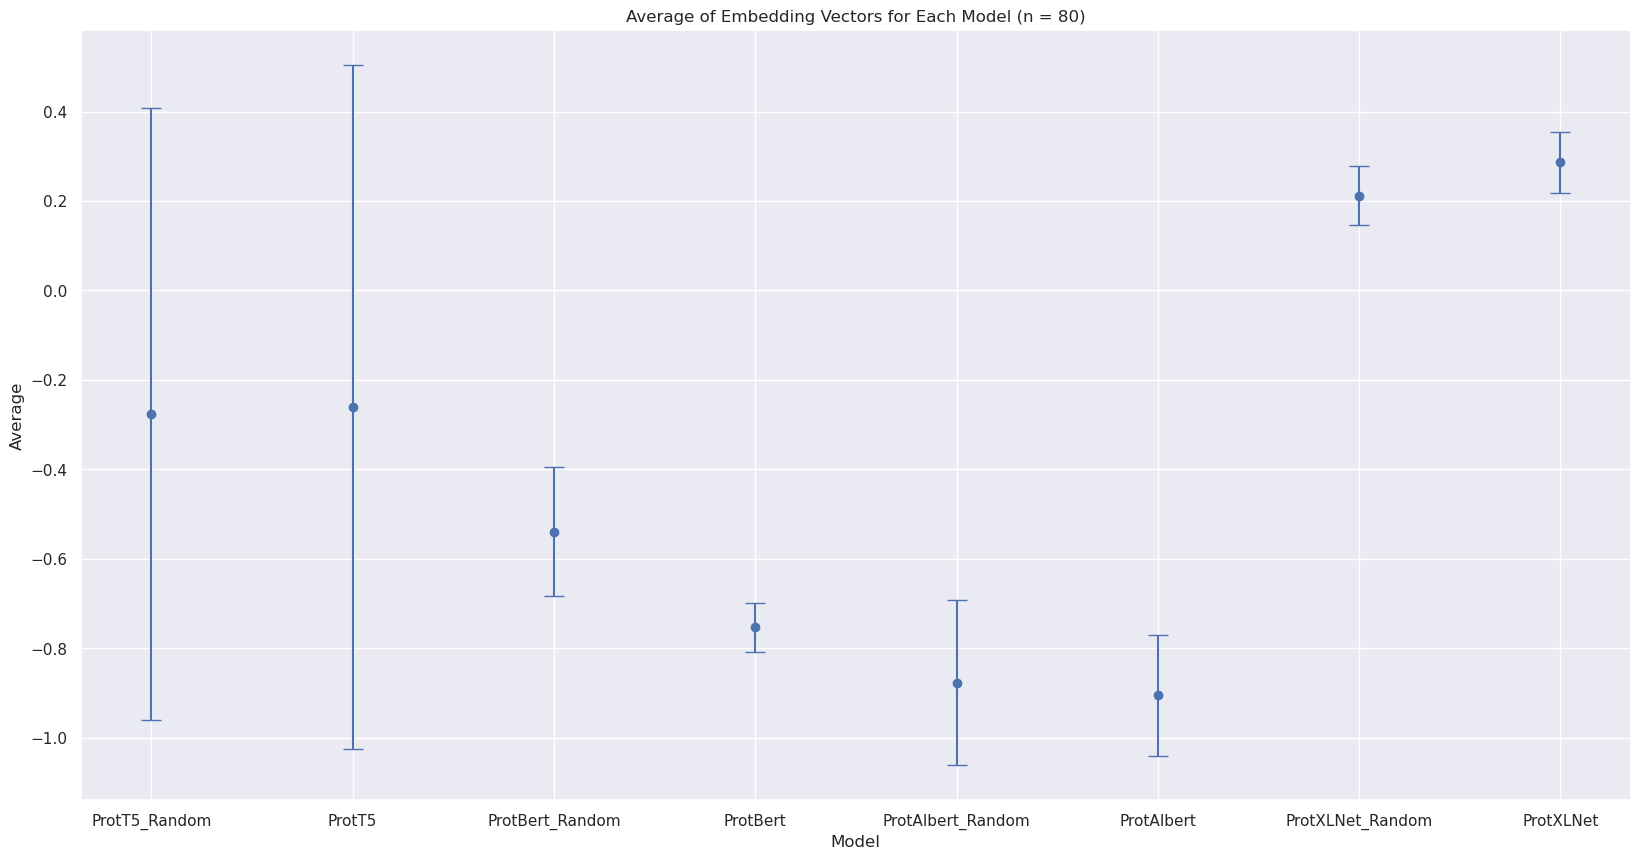

In [22]:
# Visualize the average and standard deviation for all the models together in one plot (total_average_random and total_std_random)

# Shuffle around keys: ProtT5, ProtT5_Random, ProtBert, ProtBert_Random, ProtAlbert, ProtAlbert_Random, ProtXLNet, ProtXLNet_Random
joined_avg_shuffled = {}
joined_std_shuffled = {}

for i in range(4):
    for model_name in MODELS_LIST:
        joined_avg_shuffled[model_name + "_Random"] = joined_avg[model_name + "_Random"]
        joined_std_shuffled[model_name + "_Random"] = joined_std[model_name + "_Random"]

        joined_avg_shuffled[model_name] = joined_avg[model_name]
        joined_std_shuffled[model_name] = joined_std[model_name]


plt.figure(figsize=(20, 10))
plt.errorbar(joined_avg_shuffled.keys(), joined_avg_shuffled.values(), yerr=list(joined_std_shuffled.values()), fmt='o', capsize=7)
plt.xlabel('Model')
plt.ylabel('Average')
plt.title('Average of Embedding Vectors for Each Model (n = 80)')
plt.show()

In [23]:
# Table of the average, standard deviation, and total average and standard deviation for each model
avg_table = pd.DataFrame.from_dict(total_average, orient='index', columns=['Average'])
avg_table['Standard Deviation'] = total_std.values()
avg_table['Random Average'] = total_average_random.values()
avg_table['Random Standard Deviation'] = total_std_random.values()
avg_table.head()

# Print as LaTeX table
avg_table_latex = avg_table.to_latex(escape=False, float_format="%.3f")
print(avg_table_latex)

\begin{tabular}{lrrrr}
\toprule
 & Average & Standard Deviation & Random Average & Random Standard Deviation \\
\midrule
ProtT5 & -0.261 & 0.765 & -0.277 & 0.685 \\
ProtBert & -0.754 & 0.055 & -0.540 & 0.144 \\
ProtAlbert & -0.906 & 0.135 & -0.877 & 0.184 \\
ProtXLNet & 0.286 & 0.067 & 0.211 & 0.066 \\
\bottomrule
\end{tabular}



## Cosine Similarity

#### ProtT5

In [24]:
# Retrieve average and standard deviation results for cosine similarity ProtT5
saving_add = "./analysis/"
seqs_path = "random_amino_acids_short.fasta"
scoring = MODELS_LIST[0] # ProtT5
alignment_type = ALIGNMENT_TYPES[0] # Global
model, tokenizer = get_model(scoring)
embeddings_prott5 = get_fasta_embeddings(seqs_path, model, tokenizer, scoring)

num_embeddings = len(embeddings_prott5)
avgt5 = np.zeros([num_embeddings, num_embeddings])
stdt5 = np.zeros([num_embeddings, num_embeddings])

# Compare every pair of embeddings and get cosine similarity
for i in range(num_embeddings):
    for j in range(num_embeddings):
        cosine_similarities = get_cosine_similarities(embeddings_prott5[i], embeddings_prott5[j], input="embeddings", model=model, tokenizer=tokenizer, scoring=scoring)
        avgt5[i, j] += np.mean(cosine_similarities)
        stdt5[i, j] += np.std(cosine_similarities)

avgt5a = np.mean(avgt5)
stdt5a = np.mean(stdt5)

del avgt5
del stdt5

Initializing ProtT5
ProtT5
Generating T5 Embeddings


In [25]:
# Retrieve average and standard deviation results for cosine similarity ProtT5 (non-random)
seqs_path = "nonrandom_amino_acids_short.fasta"
embeddings_prott5_nonrandom = get_fasta_embeddings(seqs_path, model, tokenizer, scoring)

num_embeddings = len(embeddings_prott5_nonrandom)
avgt5nr = np.zeros([num_embeddings, num_embeddings])
stdt5nr = np.zeros([num_embeddings, num_embeddings])

# Compare every pair of embeddings and get cosine similarity
for i in range(num_embeddings):
    for j in range(num_embeddings):
        cosine_similarities = get_cosine_similarities(embeddings_prott5_nonrandom[i], embeddings_prott5_nonrandom[j], input="embeddings", model=model, tokenizer=tokenizer, scoring=scoring)
        avgt5nr[i, j] += np.mean(cosine_similarities)
        stdt5nr[i, j] += np.std(cosine_similarities)

avgt5nra = np.mean(avgt5nr)
stdt5nra = np.mean(stdt5nr)

del avgt5nr
del stdt5nr

ProtT5
Generating T5 Embeddings


#### ProtBERT

In [26]:
# Repeat for ProtBERT
seqs_path = "random_amino_acids_short.fasta"
scoring = MODELS_LIST[1] # ProtBert
model, tokenizer = get_model(scoring)
embeddings_protbert = get_fasta_embeddings(seqs_path, model, tokenizer, scoring)

num_embeddings = len(embeddings_protbert)
avgbert = np.zeros([num_embeddings, num_embeddings])
stdbert = np.zeros([num_embeddings, num_embeddings])

# Compare every pair of embeddings and get cosine similarity
for i in range(num_embeddings):
    for j in range(num_embeddings):
        cosine_similarities = get_cosine_similarities(embeddings_protbert[i], embeddings_protbert[j], input="embeddings", model=model, tokenizer=tokenizer, scoring=scoring)
        avgbert[i, j] += np.mean(cosine_similarities)
        stdbert[i, j] += np.std(cosine_similarities)

avgberta = np.mean(avgbert)
stdberta = np.mean(stdbert)

del avgbert
del stdbert

Initializing ProtBert
ProtBert


In [27]:
# Retrieve average and standard deviation results for cosine similarity ProtBERT (non-random)
seqs_path = "nonrandom_amino_acids_short.fasta"
embeddings_protbert_nr = get_fasta_embeddings(seqs_path, model, tokenizer, scoring)

num_embeddings = len(embeddings_protbert_nr)
avgbertnr = np.zeros([num_embeddings, num_embeddings])
stdbertnr = np.zeros([num_embeddings, num_embeddings])

# Compare every pair of embeddings and get cosine similarity
for i in range(num_embeddings):
    for j in range(num_embeddings):
        cosine_similarities = get_cosine_similarities(embeddings_protbert_nr[i], embeddings_protbert_nr[j], input="embeddings", model=model, tokenizer=tokenizer, scoring=scoring)
        avgbertnr[i, j] += np.mean(cosine_similarities)
        stdbertnr[i, j] += np.std(cosine_similarities)

avgbertnra = np.mean(avgbertnr)
stdbertnra = np.mean(stdbertnr)

del avgbertnr
del stdbertnr

ProtBert


#### ProtALBERT

In [28]:
# Repeat for ProtALBERT
seqs_path = "random_amino_acids_short.fasta"
scoring = MODELS_LIST[2] # ProtALBert
model, tokenizer = get_model(scoring)
embeddings_protalbert = get_fasta_embeddings(seqs_path, model, tokenizer, scoring)

num_embeddings = len(embeddings_protalbert)
avgal = np.zeros([num_embeddings, num_embeddings])
stdal = np.zeros([num_embeddings, num_embeddings])

# Compare every pair of embeddings and get cosine similarity
for i in range(num_embeddings):
    for j in range(num_embeddings):
        cosine_similarities = get_cosine_similarities(embeddings_protalbert[i], embeddings_protalbert[j], input="embeddings", model=model, tokenizer=tokenizer, scoring=scoring)
        avgal[i, j] += np.mean(cosine_similarities)
        stdal[i, j] += np.std(cosine_similarities)

avgala = np.mean(avgal)
stdala = np.mean(stdal)

del avgal
del stdal

Initializing ProtAlbert
ProtAlbert


In [29]:
# Retrieve average and standard deviation results for cosine similarity ProtALBERT (non-random)
seqs_path = "nonrandom_amino_acids_short.fasta"
embeddings_alb_nr = get_fasta_embeddings(seqs_path, model, tokenizer, scoring)

num_embeddings = len(embeddings_alb_nr)
avgalnr = np.zeros([num_embeddings, num_embeddings])
stdalnr = np.zeros([num_embeddings, num_embeddings])

# Compare every pair of embeddings and get cosine similarity
for i in range(num_embeddings):
    for j in range(num_embeddings):
        cosine_similarities = get_cosine_similarities(embeddings_alb_nr[i], embeddings_alb_nr[j], input="embeddings", model=model, tokenizer=tokenizer, scoring=scoring)
        avgalnr[i, j] += np.mean(cosine_similarities)
        stdalnr[i, j] += np.std(cosine_similarities)

avgalnra = np.mean(avgalnr)
stdalnra = np.mean(stdalnr)

del avgalnr
del stdalnr

ProtAlbert


#### ProtXLNet

In [30]:
# Repeat for ProtXLNet
seqs_path = "random_amino_acids_short.fasta"
scoring = MODELS_LIST[3] # ProtXLNet
model, tokenizer = get_model(scoring)
embeddings_protxlnet = get_fasta_embeddings(seqs_path, model, tokenizer, scoring)

num_embeddings = len(embeddings_protxlnet)
avgxl = np.zeros([num_embeddings, num_embeddings])
stdxl = np.zeros([num_embeddings, num_embeddings])

# Compare every pair of embeddings and get cosine similarity
for i in range(num_embeddings):
    for j in range(num_embeddings):
        cosine_similarities = get_cosine_similarities(embeddings_protxlnet[i], embeddings_protxlnet[j], input="embeddings", model=model, tokenizer=tokenizer, scoring=scoring)
        avgxl[i, j] += np.mean(cosine_similarities)
        stdxl[i, j] += np.std(cosine_similarities)

avgxla = np.mean(avgxl)
stdxla = np.mean(stdxl)

del avgxl
del stdxl

Initializing ProtXLNet
ProtXLNet


In [31]:
# Retrieve average and standard deviation results for cosine similarity ProtXLNet (non-random)
seqs_path = "nonrandom_amino_acids_short.fasta"
embeddings_xl_nr = get_fasta_embeddings(seqs_path, model, tokenizer, scoring)

num_embeddings = len(embeddings_xl_nr)
avgxlnr = np.zeros([num_embeddings, num_embeddings])
stdxlnr = np.zeros([num_embeddings, num_embeddings])

# Compare every pair of embeddings and get cosine similarity
for i in range(num_embeddings):
    for j in range(num_embeddings):
        cosine_similarities = get_cosine_similarities(embeddings_xl_nr[i], embeddings_xl_nr[j], input="embeddings", model=model, tokenizer=tokenizer, scoring=scoring)
        avgxlnr[i, j] += np.mean(cosine_similarities)
        stdxlnr[i, j] += np.std(cosine_similarities)

avgxlnra = np.mean(avgxlnr)
stdxlnra = np.mean(stdxlnr)

del avgxlnr
del stdxlnr

ProtXLNet


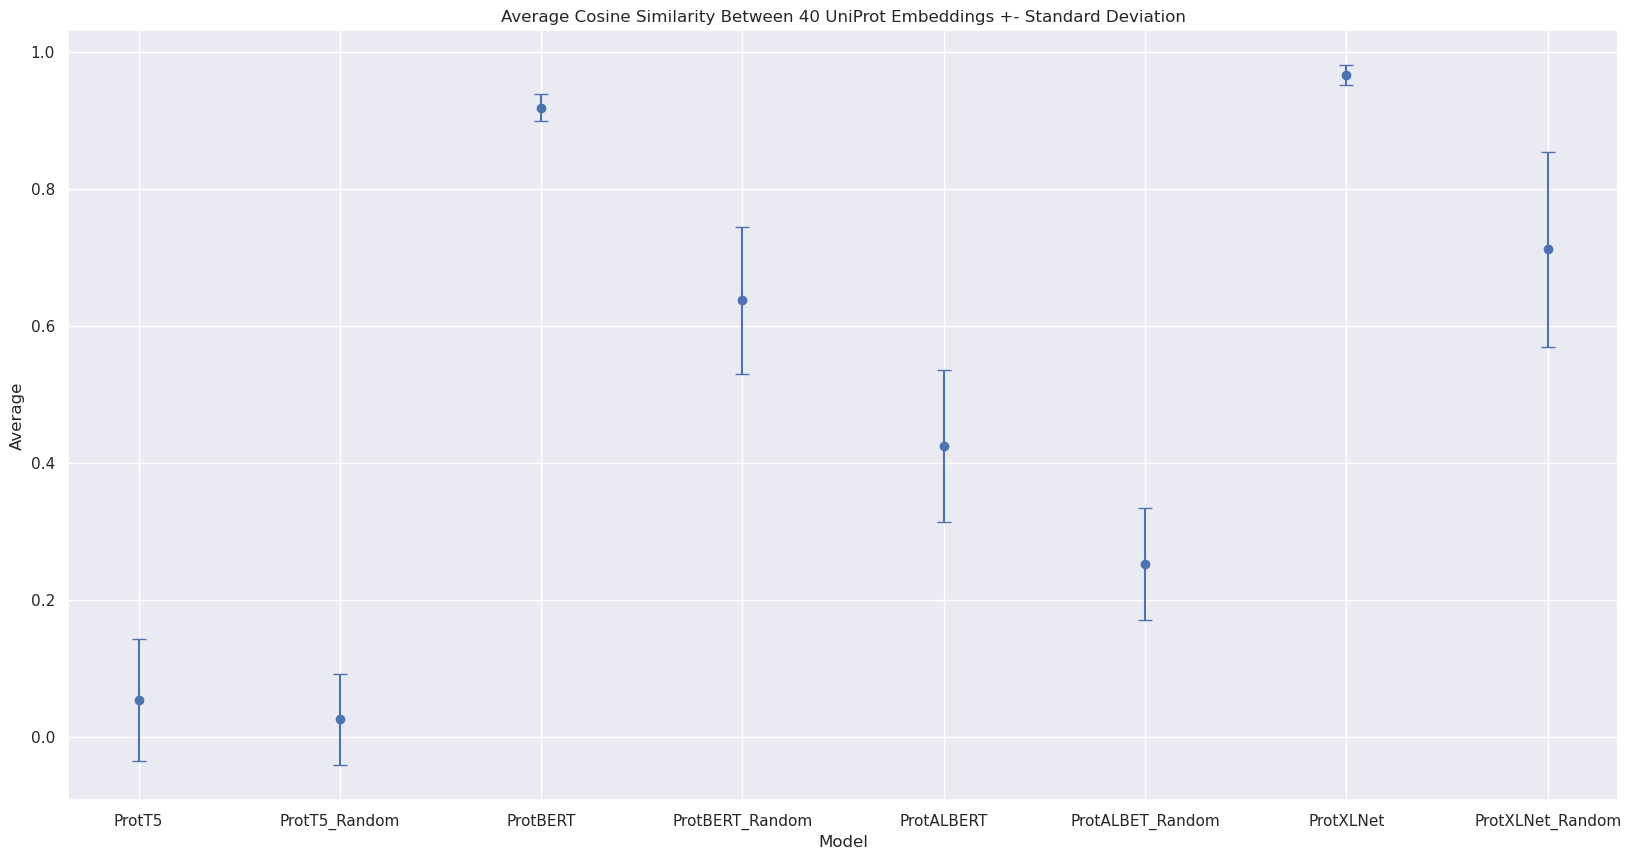

In [32]:
# Visualize the average and standard deviation for all the models together in one plot
plt.figure(figsize=(20, 10))
plt.errorbar(["ProtT5", "ProtT5_Random", "ProtBERT", "ProtBERT_Random", "ProtALBERT", "ProtALBET_Random", "ProtXLNet", "ProtXLNet_Random"], [avgt5a, avgt5nra, avgberta, avgbertnra, avgala, avgalnra, avgxla, avgxlnra], yerr=[stdt5a, stdt5nra, stdberta, stdbertnra, stdala, stdalnra, stdxla, stdxlnra], fmt='o', capsize=5)
plt.xlabel('Model')
plt.ylabel('Average')
plt.title('Average Cosine Similarity Between 40 UniProt Embeddings +- Standard Deviation')
plt.show()

In [33]:
# LaTeX Table of the average and standard deviation for all the models
avg_table = pd.DataFrame({
    "Model": ["ProtT5", "ProtT5_Random", "ProtBERT", "ProtBERT_Random", "ProtALBERT", "ProtALBERT_Random", "ProtXLNet", "ProtXLNet_Random"],
    "Average": [avgt5a, avgt5nra, avgberta, avgbertnra, avgala, avgalnra, avgxla, avgxlnra],
    "Standard Deviation": [stdt5a, stdt5nra, stdberta, stdbertnra, stdala, stdalnra, stdxla, stdxlnra]
})
avg_table_latex = avg_table.to_latex(escape=False, float_format="%.3f")
print(avg_table_latex)

\begin{tabular}{llrr}
\toprule
 & Model & Average & Standard Deviation \\
\midrule
0 & ProtT5 & 0.053 & 0.089 \\
1 & ProtT5_Random & 0.025 & 0.067 \\
2 & ProtBERT & 0.919 & 0.020 \\
3 & ProtBERT_Random & 0.637 & 0.108 \\
4 & ProtALBERT & 0.424 & 0.111 \\
5 & ProtALBERT_Random & 0.252 & 0.082 \\
6 & ProtXLNet & 0.966 & 0.015 \\
7 & ProtXLNet_Random & 0.712 & 0.142 \\
\bottomrule
\end{tabular}



## Correlations

In [ ]:
# Determining significance of the differences between the average cosine similarity of the random and non-random sequences
# Perform a t-test to determine the significance of the differences between the average cosine similarity of the random and non-random sequences
ttest_t5 = sp.stats.ttest_ind(avgt5.flatten(), avgt5nr.flatten())
ttest_bert = sp.stats.ttest_ind(avgbert.flatten(), avgbertnr.flatten())
ttest_albert = sp.stats.ttest_ind(avgal.flatten(), avgalnr.flatten())
ttest_xlnet = sp.stats.ttest_ind(avgxl.flatten(), avgxlnr.flatten())

# Print the results of the t-test
print("ProtT5:", ttest_t5)
print("ProtBERT:", ttest_bert)
print("ProtALBERT:", ttest_albert)
print("ProtXLNet:", ttest_xlnet)

In [ ]:
# Determining significance of the differences between the standard deviation of the random and non-random sequences
# Perform a t-test to determine the significance of the differences between the standard deviation of the random and non-random sequences
ttest_t5_std = sp.stats.ttest_ind(stdt5.flatten(), stdt5nr.flatten())
ttest_bert_std = sp.stats.ttest_ind(stdbert.flatten(), stdbertnr.flatten())
ttest_albert_std = sp.stats.ttest_ind(stdal.flatten(), stdalnr.flatten())
ttest_xlnet_std = sp.stats.ttest_ind(stdxl.flatten(), stdxlnr.flatten())

# Print the results of the t-test
print("ProtT5:", ttest_t5_std)
print("ProtBERT:", ttest_bert_std)
print("ProtALBERT:", ttest_albert_std)
print("ProtXLNet:", ttest_xlnet_std)